In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from scipy.fftpack import fft, rfft, dct
import matplotlib.pyplot as plt
import wave

In [2]:
test_wav = '../speech2text/datasets/cpm_cut/0_1.wav'

## Normalization + plotting

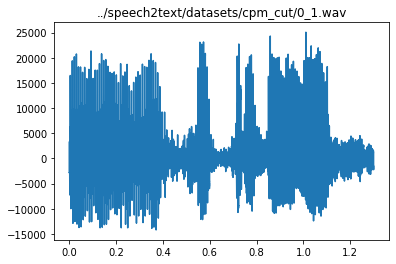

In [3]:
def normalize_signal(signal, bits_per_sample=16):
    return [(sample/2**bits_per_sample)*2 for sample in signal]

def plot_signal(signal, framerate, title=''):
    y_time = np.linspace(0, len(signal) / framerate, num=len(signal))
    plt.figure(1)
    plt.plot(y_time, signal)
    plt.title(title)
    plt.show()

def plot_wav_file(filename):
    spf = wave.open(filename, 'r')
    signal = spf.readframes(-1)
    signal = np.frombuffer(signal, np.int16)
    #norm_signal = normalize_signal(signal)
    fr = spf.getframerate()

    if spf.getnchannels() == 2:
        print('File has more then one channel, returning...')
        return

    plot_signal(signal, fr, filename)

plot_wav_file(test_wav)

## Opening file, getting metadata

In [4]:
spf = wave.open(test_wav, 'r')
signal = np.frombuffer(spf.readframes(-1), np.int16)
framerate = spf.getframerate()

## Pre-emphasis

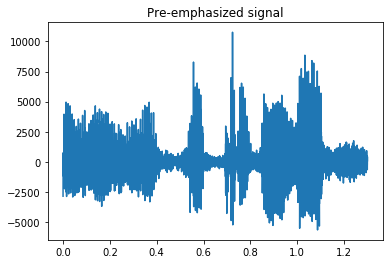

In [5]:
def pre_emphasize(signal, alpha):
    return np.append(signal[0], signal[1:] - alpha * signal[:-1])

plot_signal(pre_emphasize(signal, 0.97), framerate, 'Pre-emphasized signal')

## Framing
Cutting signal into speech frames. 

Typically 20 ms to 40 ms with 50% (+/-10%) overlap (size - stride) between consecutive frames

In [6]:
def frame_signal(signal, framerate=16000, frame_size=0.025, frame_stride=0.01):
    #frame_size = 0.025 # 25 ms cuts
    #frame_stride = 0.01 # 10 ms overlap

    frame_length, frame_step = int(round(frame_size * framerate)), \
                               int(round(frame_stride * framerate))  # seconds -> samples
    signal_length = len(signal)
    num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))  # at least 1

    padded_signal_length = num_frames * frame_step + frame_length # length with neccessary padding (for equal length of frames)
    padding = np.zeros((padded_signal_length - signal_length)) # the padding itself
    padded_signal = np.append(signal, padding) # pad the signal before cutting

    indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + \
              np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T # sequences of indeces for each frame - 2D matrix, where lines are individual frames

    return padded_signal[indices.astype(np.int32, copy=False)]

print(frame_signal(signal))

[[-2841. -2844. -2718. ... -3233. -1609.   -17.]
 [-2615. -3153. -3501. ... -3423. -2951. -2321.]
 [-1393. -1293. -1318. ... -2036. -2651. -3372.]
 ...
 [-2098. -1741.  -610. ...  -144.  -331.   -78.]
 [  610.    88.   121. ...   786.   470.   372.]
 [ -345.  -369.   -86. ...   426.   744.   722.]]


## Hamming windows

In [7]:
def hamming_windows(frames):
    return frames * np.hamming(len(frames[0]))

print(hamming_windows(frame_signal(signal)))

[[-227.28       -227.68220431 -218.06003374 ... -259.37751622
  -128.81176749   -1.36      ]
 [-209.2        -252.41982778 -280.87865274 ... -274.62085927
  -236.24830694 -185.68      ]
 [-111.44       -103.51374479 -105.7406639  ... -163.34445501
  -212.23119678 -269.76      ]
 ...
 [-167.84       -139.37929596  -48.939154   ...  -11.55284947
   -26.49887821   -6.24      ]
 [  48.8           7.04501898    9.70760268 ...   63.05930336
    37.62680592   29.76      ]
 [ -27.6         -29.5410455    -6.89961843 ...   34.17717968
    59.5624332    57.76      ]]


## N-point FFT (STFT) + power spectrum (periodogram)

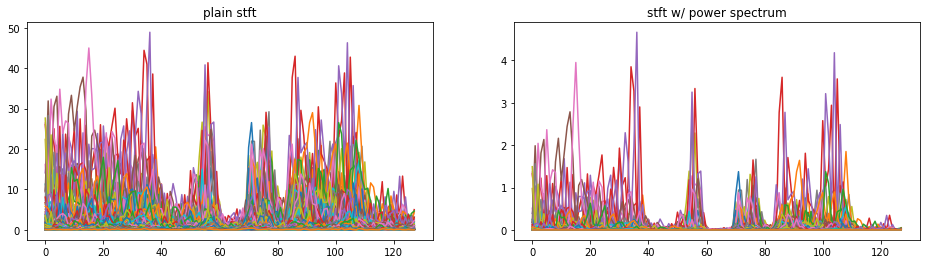

In [8]:
def stft(frames, n_points=512, pow_spect=True):
    fft_frames = np.absolute(rfft(normalize_signal(frames), n_points))
    if pow_spect:
        result = ((1.0 / n_points) * ((fft_frames) ** 2))
    else:
        result = fft_frames
    return result

plt.figure(figsize=(16, 4))
plt.subplot(121)
plt.title('plain stft')
_ = plt.plot(stft(frame_signal(signal), n_points=512, pow_spect=False))
plt.subplot(122)
plt.title('stft w/ power spectrum')
_ = plt.plot(stft(frame_signal(signal), n_points=512, pow_spect=True))
plt.show()

## Filter banks - Mel-Scale

In [9]:
def freq_to_mel(frequency):
    return 1127*np.log(1 + frequency/700)

def mel_to_freq(mel):
    return 700*(np.exp(mel/1127) - 1)

In [10]:
def mel_scale_filter(frames, n_filters=26, nfft_points=512, min_mel=0, max_mel=freq_to_mel(8000)):
    # max_mel is standardly set to mel(framerate/2) as a maximum mel for the given framerate
    mel_points = np.linspace(min_mel, max_mel, n_filters + 2)  # equally spaced points in Mel space
    freq_points = mel_to_freq(mel_points) # convert those point to Hz

    bins = np.floor((nfft_points + 1) * freq_points / framerate) # 
    filter_banks = np.zeros((n_filters, int(np.floor(nfft_points)))) # TODO: nfft_points should be divided by 2 a so probably should be the outcome of stft function
    
    for p in range(1, n_filters + 1):
        lower_bin = int(bins[p - 1])
        center_bin = int(bins[p])
        upper_bin = int(bins[p + 1])

        # fill the apropriate parts of filter banks with non zero values
        for k in range(lower_bin, center_bin): # increasing part
            filter_banks[p - 1, k] = (k - bins[p - 1]) / (bins[p] - bins[p - 1])
        for k in range(center_bin, upper_bin): # decreasing part
            filter_banks[p - 1, k] = (bins[p + 1] - k) / (bins[p + 1] - bins[p])
    
    result = np.dot(frames, filter_banks.T) # matrix multiplication
    result = np.where(result == 0, np.finfo(float).eps, result) # substitute zeros with minimal recognizable float value
    return 20 * np.log10(result)  # dB
    #return result

In [12]:
def print_spectrogram(frames, title=''):
    plt.figure(figsize=(16,5))
    plt.title(title)
    _ = plt.imshow(frames.T, origin='lower')
    plt.show()

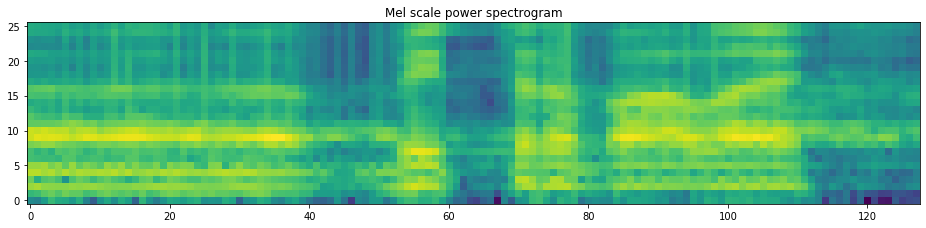

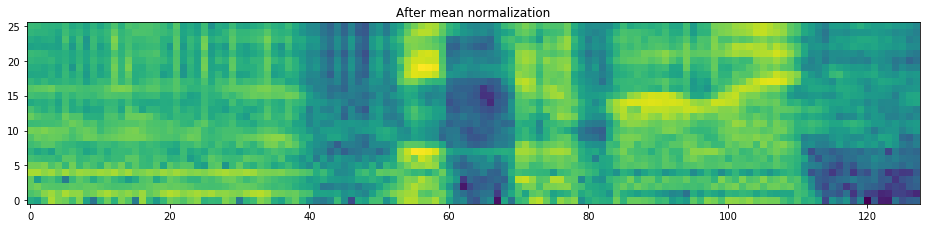

In [21]:
frames = frame_signal(signal)
stft_frames = stft(frames, n_points=512)
stft_windows = hamming_windows(stft_frames)
mel_scaled_frames = mel_scale_filter(stft_windows, n_filters=26)

print_spectrogram(mel_scaled_frames, title='Mel scale power spectrogram')

mel_scaled_frames_norm = mel_scaled_frames - (np.mean(mel_scaled_frames, axis=0) + 1e-8)

print_spectrogram(mel_scaled_frames_norm, title='After mean normalization')

## Cepstral Coefficients
Filter bank coefficients computed in the previous step are highly correlated, which could be problematic in some machine learning algorithms. Therefore, we can apply Discrete Cosine Transform (DCT) to decorrelate the filter bank coefficients and yield a compressed representation of the filter banks.

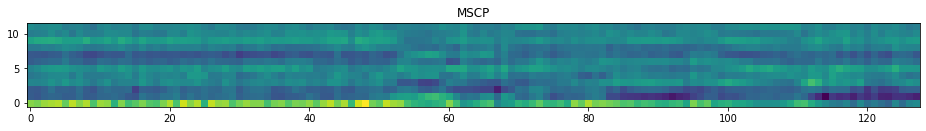

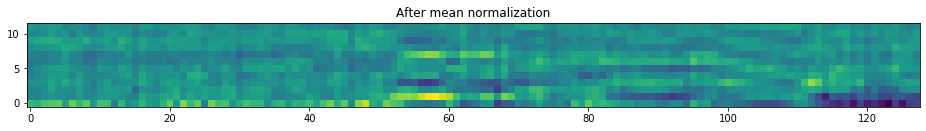

In [23]:
num_coeffs = 12
mel_scale_ceps_coeffs = dct(mel_scaled_frames, type=2, axis=1, norm='ortho')[:, 1 : (num_coeffs + 1)] # Keep 2-13

print_spectrogram(mel_scale_ceps_coeffs, title='MSCP')

mel_scale_ceps_coeffs_norm = mel_scale_ceps_coeffs - (np.mean(mel_scale_ceps_coeffs, axis=0) + 1e-8)

print_spectrogram(mel_scale_ceps_coeffs_norm, title='After mean normalization')